## Create xml for training images

In [1]:
import xml.etree.cElementTree as ET
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image, ImageDraw
from detecto import core, utils, visualize
import matplotlib.pyplot as plt
import os
from ast import literal_eval
from imutils import paths

In [2]:
## read training csv file
wd = os.getcwd()
train = pd.read_csv( wd + "\\global-wheat-detection\\train.csv")
train.head()

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

In [3]:
print(train.width.unique())
print(train.height.unique())

[1024]
[1024]


- All images are 1024 x 1024


In [4]:
# calculate xmax, ymax
bboxs = [ bbox[1:-1].split(', ') for bbox in train['bbox']]
bboxs = [ f"{int(float(bbox[0]))},{int(float(bbox[1]))},{int(float(bbox[0]))+ int(float(bbox[2]))},{int(float(bbox[1])) + int(float(bbox[3]))},wheat" for bbox in bboxs]
train['bbox_'] = bboxs
train.head()

image_id  width  height                         bbox   source  \
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1   
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1   
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1   
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1   
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1   

                   bbox_  
0  834,222,890,258,wheat  
1  226,548,356,606,wheat  
2  377,504,451,664,wheat  
3   834,95,943,202,wheat  
4   26,144,150,261,wheat

In [5]:
# for each unique image, create a dictionary of {image:bbox}
uid = train['image_id'].unique()

image_bbox_dict = {}

for image_id in (uid):
    annt_list = train.loc[train['image_id'] == image_id, 'bbox_'].values.tolist()
    image_bbox_dict[image_id] = annt_list
    
image_bbox_dict

{'b6ab77fd7': ['834,222,890,258,wheat',
  '226,548,356,606,wheat',
  '377,504,451,664,wheat',
  '834,95,943,202,wheat',
  '26,144,150,261,wheat',
  '569,382,688,493,wheat',
  '52,602,134,647,wheat',
  '627,302,749,377,wheat',
  '412,367,480,449,wheat',
  '953,220,1009,323,wheat',
  '30,70,156,203,wheat',
  '35,541,81,587,wheat',
  '103,60,220,143,wheat',
  '417,4,527,95,wheat',
  '764,299,883,392,wheat',
  '539,58,597,188,wheat',
  '139,274,260,350,wheat',
  '461,634,579,698,wheat',
  '215,634,328,709,wheat',
  '134,903,261,952,wheat',
  '737,545,824,593,wheat',
  '292,930,335,976,wheat',
  '0,827,86,885,wheat',
  '324,44,381,114,wheat',
  '663,794,779,858,wheat',
  '325,730,401,802,wheat',
  '155,554,229,624,wheat',
  '783,833,853,924,wheat',
  '534,46,607,270,wheat',
  '155,281,261,419,wheat',
  '101,240,183,315,wheat',
  '583,329,663,412,wheat',
  '36,595,128,636,wheat',
  '0,487,46,558,wheat',
  '25,482,76,542,wheat',
  '160,689,300,763,wheat',
  '202,702,306,786,wheat',
  '852,677

In [6]:
len(image_bbox_dict)

3373

In [7]:
# function to indent xml properly
def indent(elem, level=0):
    i = "\n" + level*"  "
    if len(elem):
        if not elem.text or not elem.text.strip():
            elem.text = i + "  "
        if not elem.tail or not elem.tail.strip():
            elem.tail = i
        for elem in elem:
            indent(elem, level+1)
        if not elem.tail or not elem.tail.strip():
            elem.tail = i
    else:
        if level and (not elem.tail or not elem.tail.strip()):
            elem.tail = i

In [8]:
def create_labimg_xml(image_path, annotation_list):

    image_path = Path(image_path)
    img = np.array(Image.open(image_path).convert('RGB'))

    annotation = ET.Element('annotation')
    ET.SubElement(annotation, 'folder').text = str(image_path.parent.name)
    ET.SubElement(annotation, 'filename').text = str(image_path.name)
    ET.SubElement(annotation, 'path').text = str(image_path)

    source = ET.SubElement(annotation, 'source')
    ET.SubElement(source, 'database').text = 'Unknown'

    size = ET.SubElement(annotation, 'size')
    ET.SubElement(size, 'width').text = str (img.shape[1])
    ET.SubElement(size, 'height').text = str(img.shape[0])
    ET.SubElement(size, 'depth').text = str(img.shape[2])

    ET.SubElement(annotation, 'segmented').text = '0'

    for annot in annotation_list:
        tmp_annot = annot.split(',')
        cords, label = tmp_annot[0:-1], tmp_annot[-1]
        xmin, ymin, xmax, ymax = cords[0], cords[1], cords[2], cords[3]

        object = ET.SubElement(annotation, 'object')
        ET.SubElement(object, 'name').text = label
        ET.SubElement(object, 'pose').text = 'Unspecified'
        ET.SubElement(object, 'truncated').text = '0'
        ET.SubElement(object, 'difficult').text = '0'

        bndbox = ET.SubElement(object, 'bndbox')
        ET.SubElement(bndbox, 'xmin').text = str(xmin)
        ET.SubElement(bndbox, 'ymin').text = str(ymin)
        ET.SubElement(bndbox, 'xmax').text = str(xmax)
        ET.SubElement(bndbox, 'ymax').text = str(ymax)

    indent(annotation)
    tree = ET.ElementTree(annotation)
    xml_file_name = image_path.parent / (image_path.name.split('.')[0]+'.xml')
    tree.write(xml_file_name)



In [9]:
for key in image_bbox_dict:
    anotation_list = image_bbox_dict[key]
    print('INFO: processing ' + key + '.jpg')
    create_labimg_xml('C:/Users/kohsi/Desktop/wheat_detection/global-wheat-detection/train/' + key + '.jpg', anotation_list)
    

INFO: processing b6ab77fd7.jpg
INFO: processing b53afdf5c.jpg
INFO: processing 7b72ea0fb.jpg
INFO: processing 91c9d9c38.jpg
INFO: processing 41c0123cc.jpg
INFO: processing c682d8c66.jpg
INFO: processing e46378032.jpg
INFO: processing 71fd03d51.jpg
INFO: processing 83a5d8ac8.jpg
INFO: processing 02b6f199c.jpg
INFO: processing 1bda74f14.jpg
INFO: processing 3e1e66c76.jpg
INFO: processing 4a3f67d2e.jpg
INFO: processing 2ccec6dcc.jpg
INFO: processing 0435654cd.jpg
INFO: processing 372d12c55.jpg
INFO: processing f5093f57d.jpg
INFO: processing c6b4933f7.jpg
INFO: processing 895420d9f.jpg
INFO: processing 8d6bb70e5.jpg
INFO: processing 531acb360.jpg
INFO: processing 4aeb37788.jpg
INFO: processing afb7671e5.jpg
INFO: processing cc9092474.jpg
INFO: processing c3c03e0b7.jpg
INFO: processing 42e247347.jpg
INFO: processing 5738fcf14.jpg
INFO: processing 31a6e55f2.jpg
INFO: processing ca4cb597b.jpg
INFO: processing 4e5c1078d.jpg
INFO: processing 29e44e305.jpg
INFO: processing 43e3ccd92.jpg
INFO: pr

INFO: processing 1dbd065ce.jpg
INFO: processing d3b3b5628.jpg
INFO: processing d1d96eae9.jpg
INFO: processing a700357af.jpg
INFO: processing 4762899a8.jpg
INFO: processing a7c24c3a8.jpg
INFO: processing 9d8a3a164.jpg
INFO: processing 1fe63a46a.jpg
INFO: processing c07795af6.jpg
INFO: processing 24dda66d6.jpg
INFO: processing 2dbaac896.jpg
INFO: processing 546a0e9fc.jpg
INFO: processing d7612c04a.jpg
INFO: processing eb3cffc94.jpg
INFO: processing 84d4ca3d3.jpg
INFO: processing 70cfaefe9.jpg
INFO: processing 2041a2d49.jpg
INFO: processing ab026459d.jpg
INFO: processing 2fc0fadfa.jpg
INFO: processing 2d159a876.jpg
INFO: processing 1f9a8abcd.jpg
INFO: processing 8a7d9b4b0.jpg
INFO: processing fe0d6c114.jpg
INFO: processing aa10c1bab.jpg
INFO: processing b1341e5ff.jpg
INFO: processing 1908103f1.jpg
INFO: processing 8841bcb77.jpg
INFO: processing aeb9f155b.jpg
INFO: processing 5cda6a08c.jpg
INFO: processing b6a159fd4.jpg
INFO: processing 19fd72f8b.jpg
INFO: processing b95fd89e3.jpg
INFO: pr

INFO: processing b61e3461d.jpg
INFO: processing eb9965e00.jpg
INFO: processing 772be0d11.jpg
INFO: processing 461d55f4b.jpg
INFO: processing a0c25ba9c.jpg
INFO: processing 87a35ba94.jpg
INFO: processing 14c66436c.jpg
INFO: processing a2b9aabde.jpg
INFO: processing aff4e0a02.jpg
INFO: processing 1c3032ee8.jpg
INFO: processing 9c0466c9f.jpg
INFO: processing 79a1d0dad.jpg
INFO: processing 5a0e2133c.jpg
INFO: processing a0f951ca5.jpg
INFO: processing 037024e13.jpg
INFO: processing 12e8267b0.jpg
INFO: processing 39ad9affa.jpg
INFO: processing 3d1c7f78a.jpg
INFO: processing 1478a43f1.jpg
INFO: processing 15c21964a.jpg
INFO: processing eba411885.jpg
INFO: processing ecad4b636.jpg
INFO: processing 45a0724bf.jpg
INFO: processing 34b5b6acb.jpg
INFO: processing 3a1c78a92.jpg
INFO: processing bb3a2e25d.jpg
INFO: processing 16d922704.jpg
INFO: processing f1aaca96f.jpg
INFO: processing f3fcfaa0d.jpg
INFO: processing 9983d297c.jpg
INFO: processing 3eeb41f2a.jpg
INFO: processing 9644dd8a1.jpg
INFO: pr

INFO: processing bb67d5c2e.jpg
INFO: processing 868b0ff7e.jpg
INFO: processing 16d26f266.jpg
INFO: processing 51f539ed6.jpg
INFO: processing a3ec4d1d3.jpg
INFO: processing 06b42df4e.jpg
INFO: processing 2b7b5621c.jpg
INFO: processing 6a888dbcf.jpg
INFO: processing a40ab0738.jpg
INFO: processing 24fb4b33d.jpg
INFO: processing 5a61c3e15.jpg
INFO: processing 86b661ae0.jpg
INFO: processing a6c1cc190.jpg
INFO: processing 962ccb192.jpg
INFO: processing 46930c2f2.jpg
INFO: processing ed59f37d2.jpg
INFO: processing 7f4f977bf.jpg
INFO: processing 2d990708e.jpg
INFO: processing e9491d2d6.jpg
INFO: processing a5c5d1e9f.jpg
INFO: processing 2e867b62b.jpg
INFO: processing cabe03050.jpg
INFO: processing a70061d2b.jpg
INFO: processing fefd59985.jpg
INFO: processing d2ae1e503.jpg
INFO: processing 6f24b1bab.jpg
INFO: processing e4b256788.jpg
INFO: processing fe029eca4.jpg
INFO: processing 2e262da1c.jpg
INFO: processing ba290b964.jpg
INFO: processing 119969932.jpg
INFO: processing 4cfb86eff.jpg
INFO: pr

INFO: processing 5792ad7e6.jpg
INFO: processing 8ad93457c.jpg
INFO: processing 2f53b1a20.jpg
INFO: processing 348059f04.jpg
INFO: processing 87c6acaae.jpg
INFO: processing df0be3f16.jpg
INFO: processing c52f29668.jpg
INFO: processing 078d5b8b9.jpg
INFO: processing a3cf26f70.jpg
INFO: processing e4ba46588.jpg
INFO: processing f4c7f63e6.jpg
INFO: processing 61ff5cdc2.jpg
INFO: processing b6324ea82.jpg
INFO: processing 5a5fff341.jpg
INFO: processing 3e9bf50b6.jpg
INFO: processing fc8cf268b.jpg
INFO: processing fbecfeba8.jpg
INFO: processing ff1716939.jpg
INFO: processing 2cc49e1ba.jpg
INFO: processing 1ff3f11c4.jpg
INFO: processing b0833ce3d.jpg
INFO: processing 768a74e08.jpg
INFO: processing 8a5310dc4.jpg
INFO: processing 1708360c3.jpg
INFO: processing 5ccb447e6.jpg
INFO: processing 0b9624bd4.jpg
INFO: processing 666ca30b3.jpg
INFO: processing c6454073b.jpg
INFO: processing 4af27998f.jpg
INFO: processing f6d969b95.jpg
INFO: processing e1cff2554.jpg
INFO: processing 0923194d6.jpg
INFO: pr

INFO: processing 93224e554.jpg
INFO: processing 0abc443ae.jpg
INFO: processing 5fdc74081.jpg
INFO: processing 05e946e1f.jpg
INFO: processing c720c9774.jpg
INFO: processing 03dd40d7b.jpg
INFO: processing 93648317d.jpg
INFO: processing b4424d3cc.jpg
INFO: processing 025ea7326.jpg
INFO: processing 3455cbc17.jpg
INFO: processing 02f0fe2ca.jpg
INFO: processing b2efe29e7.jpg
INFO: processing 5e6a9d355.jpg
INFO: processing 5e7aab7a2.jpg
INFO: processing f52f20733.jpg
INFO: processing b696f57e0.jpg
INFO: processing 461376287.jpg
INFO: processing dded96348.jpg
INFO: processing f1a8585e0.jpg
INFO: processing f5e3315ab.jpg
INFO: processing cc1a14dfc.jpg
INFO: processing 05c6591ee.jpg
INFO: processing 15d56204e.jpg
INFO: processing 2fc7b5c3a.jpg
INFO: processing 156282051.jpg
INFO: processing 72bb74284.jpg
INFO: processing c6d94be4c.jpg
INFO: processing 51f2e0a05.jpg
INFO: processing 0cca0ffc8.jpg
INFO: processing f51be4839.jpg
INFO: processing e7a1b379d.jpg
INFO: processing 29f09fa58.jpg
INFO: pr

INFO: processing 251ed33a8.jpg
INFO: processing 0877092cc.jpg
INFO: processing 3fa57b900.jpg
INFO: processing aca4fa91a.jpg
INFO: processing 57a0bb1bd.jpg
INFO: processing 5d3b4d154.jpg
INFO: processing 84f077ae5.jpg
INFO: processing a4084fc8c.jpg
INFO: processing fe125f8a6.jpg
INFO: processing a0b9b2399.jpg
INFO: processing 2de7cc0c9.jpg
INFO: processing 9d9b579c6.jpg
INFO: processing b79a35c8d.jpg
INFO: processing daab3de13.jpg
INFO: processing c0217fd95.jpg
INFO: processing ce803c694.jpg
INFO: processing f79336a8e.jpg
INFO: processing 07f519e11.jpg
INFO: processing 8cad1a1e0.jpg
INFO: processing e67200e55.jpg
INFO: processing 27e4c01d7.jpg
INFO: processing fa0f32e52.jpg
INFO: processing f4f169106.jpg
INFO: processing 2e1ed4321.jpg
INFO: processing 27ab890c9.jpg
INFO: processing b6f8a915e.jpg
INFO: processing b88fcdafb.jpg
INFO: processing 504dc181d.jpg
INFO: processing 9f2963463.jpg
INFO: processing 9d0f63de7.jpg
INFO: processing a81f68e82.jpg
INFO: processing 9b58d4c4e.jpg
INFO: pr

INFO: processing 7e69fb4da.jpg
INFO: processing dda3868c0.jpg
INFO: processing ca3101e66.jpg
INFO: processing 1aa099fd7.jpg
INFO: processing 4ae715446.jpg
INFO: processing 4b3d92c5e.jpg
INFO: processing dd3e3f071.jpg
INFO: processing 200b3c316.jpg
INFO: processing 32a203fe5.jpg
INFO: processing 767e515ec.jpg
INFO: processing e277cec54.jpg
INFO: processing cd2578a38.jpg
INFO: processing 1ab041b77.jpg
INFO: processing 25cd221bb.jpg
INFO: processing e891c64c3.jpg
INFO: processing 84e6957ae.jpg
INFO: processing 43ab45d4b.jpg
INFO: processing b3b2e3768.jpg
INFO: processing a346a6b04.jpg
INFO: processing 614b1d8c5.jpg
INFO: processing 0f9100915.jpg
INFO: processing 0ee812df9.jpg
INFO: processing f01ed3f24.jpg
INFO: processing d3286c089.jpg
INFO: processing 3542457e2.jpg
INFO: processing 46630486d.jpg
INFO: processing 060543bbf.jpg
INFO: processing 4972999e9.jpg
INFO: processing 5c2312362.jpg
INFO: processing d13ac0b3f.jpg
INFO: processing aaf9d5f5c.jpg
INFO: processing b69255534.jpg
INFO: pr

INFO: processing 5f76c9a35.jpg
INFO: processing a4bce62ff.jpg
INFO: processing 4fc5adf2d.jpg
INFO: processing 10c433ecf.jpg
INFO: processing 8af29abc4.jpg
INFO: processing 233494bf0.jpg
INFO: processing 4b0b5b4bd.jpg
INFO: processing 7de5ba231.jpg
INFO: processing c64a8e237.jpg
INFO: processing 0989b2627.jpg
INFO: processing c6357c9d8.jpg
INFO: processing 069719eab.jpg
INFO: processing 5d6935f10.jpg
INFO: processing dc7c60052.jpg
INFO: processing 4bb9bab8b.jpg
INFO: processing d07d391fc.jpg
INFO: processing 9302b9512.jpg
INFO: processing 036cbd683.jpg
INFO: processing 32f716667.jpg
INFO: processing a17be4ebe.jpg
INFO: processing 2b2612efa.jpg
INFO: processing 0bff84dd0.jpg
INFO: processing e7337325d.jpg
INFO: processing f4f62f0f8.jpg
INFO: processing e5c9056ab.jpg
INFO: processing c2b7f1929.jpg
INFO: processing 04fe56fd3.jpg
INFO: processing 644eff133.jpg
INFO: processing 57e21a852.jpg
INFO: processing 755becfe1.jpg
INFO: processing bc1666f8c.jpg
INFO: processing f1e0fb4d4.jpg
INFO: pr

INFO: processing eba970515.jpg
INFO: processing 91f19054e.jpg
INFO: processing 51af1e874.jpg
INFO: processing d63350a3d.jpg
INFO: processing 49476a3c4.jpg
INFO: processing c49ed83ce.jpg
INFO: processing 68561559e.jpg
INFO: processing a44840527.jpg
INFO: processing 49c3e4f6e.jpg
INFO: processing 0cbb43d45.jpg
INFO: processing 1adb61e33.jpg
INFO: processing 229d8a499.jpg
INFO: processing 383817085.jpg
INFO: processing af7f4eb72.jpg
INFO: processing e1258e054.jpg
INFO: processing 00b70a919.jpg
INFO: processing 250233aea.jpg
INFO: processing b3d2304bf.jpg
INFO: processing 8930b9069.jpg
INFO: processing 6d27a58b7.jpg
INFO: processing f016b9731.jpg
INFO: processing f9b92c9e9.jpg
INFO: processing c83d339fe.jpg
INFO: processing 2cae223a8.jpg
INFO: processing 45aabed56.jpg
INFO: processing d781eb0c1.jpg
INFO: processing 45a203e70.jpg
INFO: processing eddff557c.jpg
INFO: processing c94f8dd92.jpg
INFO: processing e290bc809.jpg
INFO: processing f3d0759c8.jpg
INFO: processing e142e85ad.jpg
INFO: pr

INFO: processing fd9829305.jpg
INFO: processing 7727e3256.jpg
INFO: processing 4ff1646a8.jpg
INFO: processing d73c6d06d.jpg
INFO: processing 7e971fbec.jpg
INFO: processing 48dd5506a.jpg
INFO: processing cbab952fe.jpg
INFO: processing 4767561f3.jpg
INFO: processing d098bdc9b.jpg
INFO: processing 8af4b7288.jpg
INFO: processing cce5cb631.jpg
INFO: processing dc928e94e.jpg
INFO: processing a5dde818e.jpg
INFO: processing 51bf3f631.jpg
INFO: processing f3c5e09ab.jpg
INFO: processing b00b900a1.jpg
INFO: processing 3e684e1cc.jpg
INFO: processing 93aff3b78.jpg
INFO: processing ca5e51e59.jpg
INFO: processing a57962536.jpg
INFO: processing 0557047b9.jpg
INFO: processing d69f6d767.jpg
INFO: processing 28e0fc5e4.jpg
INFO: processing 33ea56e1c.jpg
INFO: processing d728e2fc2.jpg
INFO: processing b5e726c10.jpg
INFO: processing 2ff4e8bb0.jpg
INFO: processing 30f54e611.jpg
INFO: processing a326e7d8e.jpg
INFO: processing a3bcd1d0f.jpg
INFO: processing 382bf4ed7.jpg
INFO: processing be589b720.jpg
INFO: pr

INFO: processing afe608129.jpg
INFO: processing 95ee952ba.jpg
INFO: processing a7605a14e.jpg
INFO: processing 366187e59.jpg
INFO: processing 3ead80a57.jpg
INFO: processing 3d74e4614.jpg
INFO: processing 1794c0a24.jpg
INFO: processing 773c33268.jpg
INFO: processing c4ffde64b.jpg
INFO: processing 86426e386.jpg
INFO: processing b899eec9f.jpg
INFO: processing b4661eb6f.jpg
INFO: processing ba3404681.jpg
INFO: processing 8ffe2f23a.jpg
INFO: processing 6bd3f949d.jpg
INFO: processing d17ddb23c.jpg
INFO: processing d6cd9fa5f.jpg
INFO: processing 787d3091c.jpg
INFO: processing 51d7e0c3d.jpg
INFO: processing 311498261.jpg
INFO: processing e9dc0cf8f.jpg
INFO: processing 56c1bc7f0.jpg
INFO: processing 7f4d07cc0.jpg
INFO: processing eb69f5522.jpg
INFO: processing f355c9fe2.jpg
INFO: processing c4731ac9e.jpg
INFO: processing 91ef6ef2b.jpg
INFO: processing 8d4f8b1cc.jpg
INFO: processing 6b62a043a.jpg
INFO: processing 522edf5c3.jpg
INFO: processing 463a95dac.jpg
INFO: processing cf483de89.jpg
INFO: pr

INFO: processing cacd820db.jpg
INFO: processing a9cd1638c.jpg
INFO: processing 84d992b88.jpg
INFO: processing c35743243.jpg
INFO: processing f3bc43304.jpg
INFO: processing 6e43d71ec.jpg
INFO: processing 4a29d08ab.jpg
INFO: processing efc4f0374.jpg
INFO: processing 269a5f98e.jpg
INFO: processing eefb4a7fa.jpg
INFO: processing afb9f53cd.jpg
INFO: processing a65b1b9a6.jpg
INFO: processing 48bdfec34.jpg
INFO: processing af32eb10c.jpg
INFO: processing 740d3c904.jpg
INFO: processing 4a7825bbe.jpg
INFO: processing e6277ce7c.jpg
INFO: processing 44fb6b8b2.jpg
INFO: processing 879d8a9d2.jpg
INFO: processing 340ac8d52.jpg
INFO: processing 3744f2482.jpg
INFO: processing c23c950a9.jpg
INFO: processing 6a614e72e.jpg
INFO: processing 4def855a8.jpg
INFO: processing 85e3ce681.jpg
INFO: processing 44afd181e.jpg
INFO: processing 528621931.jpg
INFO: processing a28a4ad8c.jpg
INFO: processing f9ece438e.jpg
INFO: processing 79ce67248.jpg
INFO: processing 277fa7280.jpg
INFO: processing f5607392f.jpg
INFO: pr

## Check image

- check if xml files are correct

In [10]:
TRAIN_DIR = wd + '\\global-wheat-detection\\train\\'

def display_images(image_id): 
    f, ax = plt.subplots(1,1, figsize=(8,8))
    image_path = os.path.join(TRAIN_DIR, f'{image_id}.jpg')
    image = Image.open(image_path)

    # get all bboxes for given image in [xmin, ymin, width, height]
    bboxes = [literal_eval(box) for box in train[train['image_id'] == image_id]['bbox']]
    # draw rectangles on image
    draw = ImageDraw.Draw(image)
    for bbox in bboxes:    
        draw.rectangle([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]], width=3)

    ax.imshow(image) 
    image.close()       
    ax.axis('off')

    source = train[train['image_id'] == image_id]['source'].values[0]
    ax.set_title(f"image_id: {image_id}\nSource: {source}")

    plt.show() 

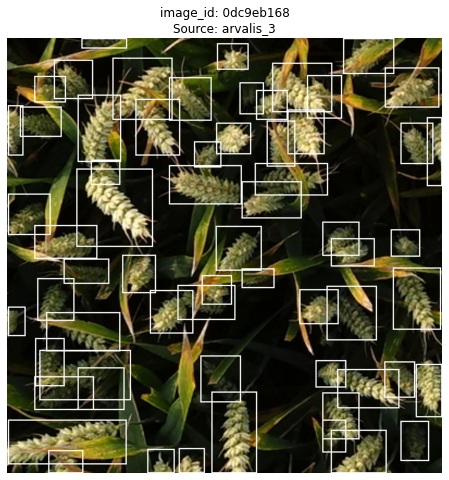

In [11]:
image_id = '0dc9eb168'
display_images(image_id)

In [12]:
from xml.etree import ElementTree
root = ElementTree.parse(wd + "\\global-wheat-detection\\train\\0dc9eb168.xml").getroot()


box_list =[]
for each in root.findall('.//bndbox/*'):
    box_list.append(int(each.text))

box_list = [box_list[x:x+4] for x in range(0, len(box_list), 4)]
print(box_list)


[[381, 299, 552, 391], [889, 69, 1017, 163], [491, 442, 599, 547], [492, 199, 574, 273], [791, 0, 911, 84], [336, 593, 438, 695], [163, 307, 343, 491], [166, 133, 268, 291], [742, 834, 829, 944], [64, 440, 212, 519], [660, 168, 747, 273], [381, 92, 481, 194], [903, 450, 972, 514], [271, 510, 350, 600], [926, 199, 1003, 296], [988, 186, 1024, 348], [494, 12, 568, 74], [908, 540, 1021, 686], [752, 583, 870, 711], [30, 161, 128, 232], [458, 558, 529, 627], [110, 51, 202, 143], [777, 779, 923, 871], [688, 591, 780, 673], [71, 565, 158, 665], [586, 122, 660, 192], [726, 758, 798, 822], [962, 767, 1024, 892], [742, 432, 829, 512], [624, 58, 765, 174], [888, 761, 960, 846], [302, 143, 407, 276], [481, 832, 588, 1024], [133, 519, 240, 578], [611, 194, 678, 302], [552, 337, 693, 424], [248, 46, 389, 192], [76, 734, 291, 852], [926, 901, 993, 995], [2, 366, 102, 463], [2, 898, 281, 1003], [440, 243, 504, 304], [762, 922, 893, 1024], [583, 294, 755, 370], [175, 0, 282, 24], [66, 706, 135, 819], [

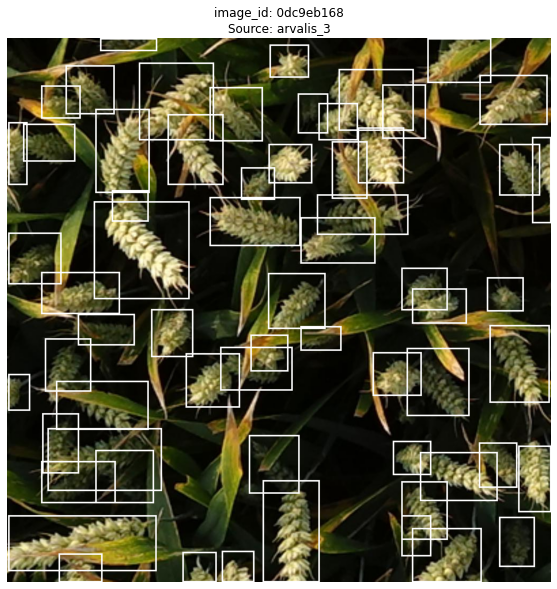

In [13]:
f, ax = plt.subplots(1,1, figsize=(10,10))

image_id = '0dc9eb168'
image_path = os.path.join(TRAIN_DIR, f'{image_id}.jpg')
image = Image.open(image_path)

# get all bboxes for given image in [xmin, ymin, width, height]
#bboxes = [literal_eval(box) for box in train[train['image_id'] == image_id]['bbox']]
bboxes2 = box_list

# draw rectangles on image
draw = ImageDraw.Draw(image)
for bbox in bboxes2:    
    draw.rectangle([bbox[0], bbox[1], bbox[2], bbox[3]], width=3)

ax.imshow(image) 
image.close()       
ax.axis('off')

source = train[train['image_id'] == image_id]['source'].values[0]
ax.set_title(f"image_id: {image_id}\nSource: {source}")

plt.show() 

##  Train Model

In [2]:
#dataset = core.Dataset('C:/Users/kohsi/Desktop/wheat_detection/global-wheat-detection/train/')
dataset = core.Dataset('C:/Users/siewlee.koh/Desktop/wheat_detection/global-wheat-detection/train/')
model = core.Model(['wheat'])

model.fit(dataset)

c:\users\siewlee.koh\desktop\wheat_detection\wheat_detection\lib\site-packages\torch\nn\functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
..\torch\csrc\utils\python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [3]:
model.save('model_weights.pth')

In [30]:
import torch
torch_model = model.get_internal_model()
print(type(torch_model))

torch.save(torch_model, 'C:/Users/siewlee.koh/Desktop/wheat_detection/global-wheat-detection/torch_model.pth')



<class 'torchvision.models.detection.faster_rcnn.FasterRCNN'>


In [33]:
torch.save(torch_model.state_dict(), "C:/Users/siewlee.koh/Desktop/wheat_detection/torch_model_state.pth")

In [ ]:
#output_dict = model(input_tensor)

### store results in df

In [14]:
# load model
model = core.Model.load('model_weights.pth', ['wheat'])

In [42]:
# Specify the path to your image
#image = utils.read_image('C:/Users/kohsi/Desktop/wheat_detection/global-wheat-detection/test/cb8d261a3.jpg')
image = utils.read_image('C:/Users/kohsi/Desktop/wheat_detection/global-wheat-detection/test/2fd875eaa.jpg')
predictions = model.predict(image)

# predictions format: (labels, boxes, scores)
labels, boxes, scores = predictions
print(labels) 

#           xmin       ymin       xmax       ymax
# tensor([[ 569.2125,  203.6702, 1003.4383,  658.1044],
#         [ 276.2478,  144.0074,  579.6044,  508.7444],
#         [ 277.2929,  162.6719,  627.9399,  511.9841]])
print(boxes)

# tensor([0.9952, 0.9837, 0.5153])
print(scores)

C:\Users\kohsi\Desktop\wheat_detection\wheat_venv\lib\site-packages\torch\nn\functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


['wheat', 'wheat', 'wheat', 'wheat', 'wheat', 'wheat', 'wheat', 'wheat', 'wheat', 'wheat', 'wheat', 'wheat', 'wheat', 'wheat', 'wheat', 'wheat', 'wheat', 'wheat', 'wheat', 'wheat', 'wheat', 'wheat', 'wheat', 'wheat', 'wheat']
tensor([[5.3608e+02, 8.6704e+02, 6.4192e+02, 9.7846e+02],
        [4.6668e+02, 3.5105e+02, 5.8571e+02, 4.4859e+02],
        [5.8727e-01, 7.3859e+02, 8.7219e+01, 8.3897e+02],
        [4.5687e+02, 4.9099e+02, 5.4060e+02, 6.3221e+02],
        [8.9028e+02, 4.7904e+01, 9.8975e+02, 1.3951e+02],
        [7.3023e+02, 1.5423e+02, 8.1270e+02, 2.3861e+02],
        [2.2064e+00, 8.1284e-01, 1.1985e+02, 7.4305e+01],
        [1.4477e+00, 9.1107e+02, 1.0399e+02, 9.8948e+02],
        [7.3367e+02, 8.8475e+02, 8.2678e+02, 9.7100e+02],
        [4.2853e+02, 6.4010e+01, 5.3579e+02, 1.3749e+02],
        [1.1078e+02, 2.9693e+01, 2.1585e+02, 1.0389e+02],
        [4.3673e+02, 9.6591e+02, 5.5437e+02, 1.0240e+03],
        [9.0966e+02, 8.8039e+02, 9.7987e+02, 9.7793e+02],
        [1.0768e+02,

In [63]:
box = boxes.numpy()
df = pd.DataFrame(box)
df.columns = ['xmin', 'ymin', 'xmax', 'ymax']
df['image_id'] = '2fd875eaa'

confidence = scores.numpy()
df['confidence'] = confidence

df['width'] = df['xmax'] - df['xmin']
df['height'] = df['ymax'] - df['ymin']

df = df.round({'confidence': 1 })
display(df.head())
cols = ['xmin', 'ymin', 'width', 'height']
df[cols] = df[cols].applymap(np.int64)

# df["xmin"] = df["xmin"].astype(int)
# df["ymin"] = df["ymin"].astype(int)
# df["width"] = df["width"].astype(int)
# df["height"] = df["height"].astype(int)
display(df.head())

#cols = ['confidence', 'xmin', 'ymin', 'width', 'height']
#df['PredictionString'] = df[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

df['PredictionString'] = df['confidence'].astype(str) + ' ' + df['xmin'].astype(str) + ' ' + \
                            df['ymin'].astype(str) + ' ' + df['width'].astype(str) + ' ' + df['height'].astype(str)
submission_df =df[["image_id", "PredictionString"]]
display(submission_df)

xmin        ymin        xmax        ymax   image_id  confidence  \
0  691.437073  203.567764  803.837891  291.324402  2fd875eaa         0.1   
1  226.098740  315.802551  332.039948  406.212830  2fd875eaa         0.1   
2  605.087402  730.919250  698.389526  812.468628  2fd875eaa         0.1   
3  822.102844  409.183167  904.817871  490.944244  2fd875eaa         0.1   
4    2.093603  840.515137   67.145256  948.468445  2fd875eaa         0.1   

        width      height  
0  112.400818   87.756638  
1  105.941208   90.410278  
2   93.302124   81.549377  
3   82.715027   81.761078  
4   65.051651  107.953308

xmin  ymin        xmax        ymax   image_id  confidence  width  height
0   691   203  803.837891  291.324402  2fd875eaa         0.1    112      87
1   226   315  332.039948  406.212830  2fd875eaa         0.1    105      90
2   605   730  698.389526  812.468628  2fd875eaa         0.1     93      81
3   822   409  904.817871  490.944244  2fd875eaa         0.1     82      81
4     2   840   67.145256  948.468445  2fd875eaa         0.1     65     107

image_id     PredictionString
0   2fd875eaa   0.1 691 203 112 87
1   2fd875eaa   0.1 226 315 105 90
2   2fd875eaa    0.1 605 730 93 81
3   2fd875eaa    0.1 822 409 82 81
4   2fd875eaa     0.1 2 840 65 107
5   2fd875eaa   0.1 322 471 131 84
6   2fd875eaa    0.1 410 174 69 65
7   2fd875eaa    0.1 158 248 73 78
8   2fd875eaa   0.1 76 463 128 138
9   2fd875eaa   0.1 948 448 75 167
10  2fd875eaa  0.1 130 740 163 120
11  2fd875eaa    0.1 553 402 66 90
12  2fd875eaa    0.1 545 280 96 93
13  2fd875eaa  0.1 397 786 193 104
14  2fd875eaa    0.1 669 114 75 86
15  2fd875eaa    0.1 261 665 93 77
16  2fd875eaa  0.1 855 605 117 168

## Predict for test images


- Predict for the 10 test images given.

C:\Users\kohsi\Desktop\wheat_detection\wheat_venv\lib\site-packages\torch\nn\functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


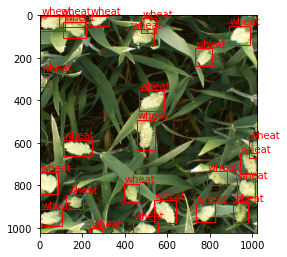

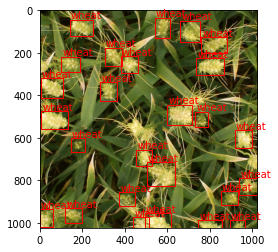

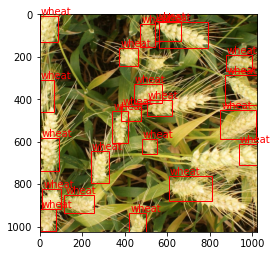

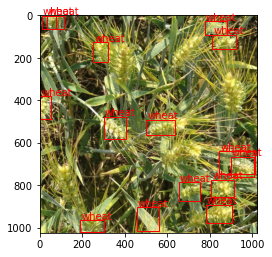

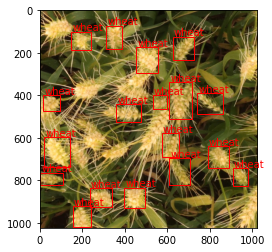

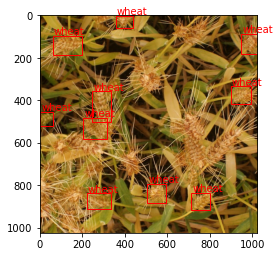

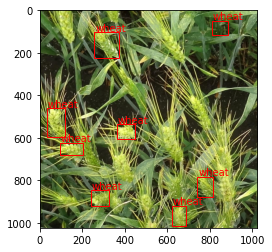

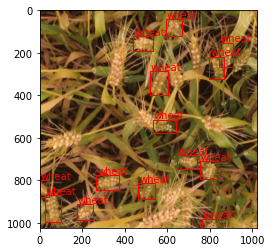

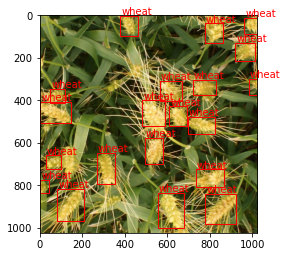

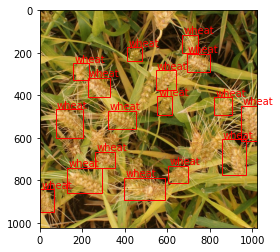

In [64]:
folder = 'C:/Users/kohsi/Desktop/wheat_detection/global-wheat-detection/test/'
appended_data = []


for img in paths.list_images(folder):
    
    # get file name
    full_filename = os.path.basename(img) 
    filename = os.path.splitext(full_filename)[0]
    
    # read and predict image
    image = utils.read_image(img)
    predictions = model.predict(image)

    # predictions format: (labels, boxes, scores)
    labels, boxes, scores = predictions
    visualize.show_labeled_image(image, boxes, labels) # display image predictions 
    
    # output results in a df
    box = boxes.numpy()
    df = pd.DataFrame(box)
    df.columns = ['xmin', 'ymin', 'xmax', 'ymax']   
    df['image_id'] = filename
    confidence = scores.numpy()
    df['confidence'] = confidence
    df['width'] = df['xmax'] - df['xmin']
    df['height'] = df['ymax'] - df['ymin']
    
    df = df.round({'confidence': 1 })
    cols = ['xmin', 'ymin', 'width', 'height']
    df[cols] = df[cols].applymap(np.int64)
    df['PredictionString'] = df['confidence'].astype(str) + ' ' + df['xmin'].astype(str) + ' ' + \
                            df['ymin'].astype(str) + ' ' + df['width'].astype(str) + ' ' + df['height'].astype(str)
    submission_df = df[["image_id", "PredictionString"]]
    
    #append df for each image
    appended_data.append(submission_df)
    
    
#export to csv   
appended_df = pd.concat(appended_data)
appended_df.to_csv('C:/Users/kohsi/Desktop/wheat_detection/submission.csv', index = False)



In [65]:
appended_df.head()

image_id     PredictionString
0  2fd875eaa  0.1 536 867 105 111
1  2fd875eaa   0.1 466 351 119 97
2  2fd875eaa     0.1 0 738 86 100
3  2fd875eaa   0.1 456 490 83 141
4  2fd875eaa     0.1 890 47 99 91

## Data Augmentation